# Experiment 04 - FastAI - ResNet-34 Pretrained

In [1]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore")

from fastai.vision.all import *
import pandas as pd
from utils.compute_metrics import get_metrics, get_majority_vote,log_test_metrics
from utils.dataframe_creation import create_dataframe_preproccessing
from sklearn.model_selection import GroupKFold
import mlflow

In [2]:
dataset = pd.read_pickle('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle')

P`<patient id [1-55]>`_image`<img id [1-10]>`.jpg

In [3]:
dataset = create_dataframe_preproccessing()
dataset.head()

,id,labels,fat,fname
0,1,0,3,data/01_raw/raw_images/P1_image1.jpg
1,1,0,3,data/01_raw/raw_images/P1_image2.jpg
2,1,0,3,data/01_raw/raw_images/P1_image3.jpg
3,1,0,3,data/01_raw/raw_images/P1_image4.jpg
4,1,0,3,data/01_raw/raw_images/P1_image5.jpg


In [6]:
test_metrics={}    
test_n_splits = 11
group_kfold_test = GroupKFold(n_splits=test_n_splits)
seed= 11
fold_c =1 
dataset = dataset[['fname','labels','id']]
df_pid = dataset['id']
df_y = dataset['labels']

test_metrics={}  
#majority vote results
test_metrics_mv={} 

for train_index, test_index in group_kfold_test.split(dataset, df_y, df_pid):
    
    random.seed(seed)
    random.shuffle(train_index)
    X_train, X_test = dataset.iloc[train_index], dataset.iloc[test_index]
    
    dls = ImageDataLoaders.from_df(X_train, './', folder='../', valid_pct=0.2, bs=16,item_tfms=Resize(224))
    
    #  dls = ImageDataLoaders.from_df(training_data, './', folder='./', valid_col='is_valid',bs=16,item_tfms=Resize(224))
    model = cnn_learner(dls, resnet34)
    model.fine_tune(5,lr=10e-3)
    predictions = [int(model.predict(X_test['fname'].iloc[i])[0]) for i in range(X_test.shape[0])]
    
    #get metrics with NO majority vote
    acc, auc, specificity, sensitivity = get_metrics(X_test['labels'], predictions)
    #compute majority vote metrics
    acc_mv, auc_mv, specificity_mv, sensitivity_mv = get_majority_vote(X_test['labels'], np.array(predictions))
    
    print('FOLD '+ str(fold_c) + ':  acc ' + str(acc) +  ', auc ' +  str(auc) +  ', specificity '+ str(specificity)
          + ', sensitivity ' + str(sensitivity))
    print('FOLD '+ str(fold_c) + ':  MV acc ' + str(acc_mv) +  ', MV auc ' +  str(auc_mv) +  ', MV specificity '+ str(specificity_mv)
          + ', MV sensitivity ' + str(sensitivity_mv))
    
    test_metrics[fold_c]=  {'acc':acc, 'auc':auc, 'sensitivity':sensitivity, 'specificity':specificity}
    test_metrics_mv[fold_c]=  {'acc':acc_mv, 'auc':auc_mv, 'sensitivity':sensitivity_mv, 'specificity':specificity_mv}
    
    fold_c +=1 
     
log_test_metrics(test_metrics, test_metrics_mv, test_n_splits, 'Pretrained Restnet-34 on ImageNet', None, seed)
    

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/gauthiers/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

TypeError: fit_one_cycle() got an unexpected keyword argument 'lr'

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=2.75422871709452e-06)

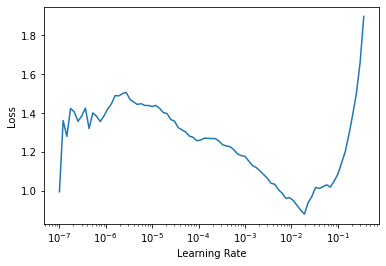

In [11]:
learn.lr_find()

In [26]:
preds = [learn.predict(test_data['fname'].iloc[i]) for i in range(test_data.shape[0])]

In [27]:
real_preds = [int(pred[0]) for pred in preds]

In [29]:
preds


[('0', tensor(0), tensor([1.0000e+00, 1.5922e-06])),
 ('0', tensor(0), tensor([9.9999e-01, 6.7350e-06])),
 ('0', tensor(0), tensor([9.9999e-01, 9.8801e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.3415e-06])),
 ('0', tensor(0), tensor([9.9998e-01, 2.0316e-05])),
 ('0', tensor(0), tensor([1.0000e+00, 6.8242e-09])),
 ('0', tensor(0), tensor([1.0000e+00, 1.2546e-07])),
 ('0', tensor(0), tensor([1.0000e+00, 1.6448e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.8203e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.9626e-06])),
 ('0', tensor(0), tensor([0.8660, 0.1340])),
 ('0', tensor(0), tensor([0.7482, 0.2518])),
 ('0', tensor(0), tensor([0.8198, 0.1802])),
 ('0', tensor(0), tensor([0.9817, 0.0183])),
 ('0', tensor(0), tensor([0.8206, 0.1794])),
 ('0', tensor(0), tensor([0.7541, 0.2459])),
 ('1', tensor(1), tensor([0.2996, 0.7004])),
 ('1', tensor(1), tensor([0.3755, 0.6245])),
 ('0', tensor(0), tensor([0.8812, 0.1188])),
 ('0', tensor(0), tensor([0.6180, 0.3820])),
 ('1', tensor(1), te

In [28]:
accuracy_score(test_data['labels'].values, np.array(real_preds))

0.9333333333333333

In [ ]:
# note the id of the patients in the test set
test_data['id'].unique()